CycleGAN is a model that aims to solve the image-to-image translation problem. The goal of the image-to-image translation problem is to learn the mapping between an input image and an output image using a training set of aligned image pairs.

The CycleGAN is an extension of the GAN architecture that involves the simultaneous training of two generator models and two discriminator models.

One generator takes images from the first domain as input and outputs images for the second domain, and the other generator takes images from the second domain as input and generates images for the first domain. Discriminator models are then used to determine how plausible the generated images are and update the generator models accordingly.

This extension alone might be enough to generate plausible images in each domain, but not sufficient to generate translations of the input images, so The CycleGAN uses an additional extension to the architecture called cycle consistency. This is the idea that an image output by the first generator could be used as input to the second generator and the output of the second generator should match the original image. The reverse is also true: that an output from the second generator can be fed as input to the first generator and the result should match the input to the second generator.

The CycleGAN encourages cycle consistency by adding an additional loss to measure the difference between the generated output of the second generator and the original image, and the reverse. This acts as a regularization of the generator models, guiding the image generation process in the new domain toward image translation.

Adversarial training can learn mappings $G$
and $F$ that produce outputs identically distributed as target
domains $Y$ and $X$ respectively. However,
with large enough capacity, a network can map the same
set of input images to any random permutation of images in
the target domain, where any of the learned mappings can
induce an output distribution that matches the target distribution. Thus, adversarial losses alone cannot guarantee
that the learned function can map an individual input $x_{i}$
to a desired output $y_{i}$. For each image $x$ from domain $X$, the image translation cycle should be able to bring $x$ back to the original image,
i.e., $x → G(x) → F(G(x)) ∼ x$. We call this forward cycle consistency. Similarly, for
each image $y$ from domain $Y$ , $G$ and $F$ should also satisfy
backward cycle consistency: $y → F(y) → G(F(y)) ∼ y$.

This behavior incentivized using a cycle consistency loss.

For the discriminator networks, CycleGAN will use 70 × 70
PatchGANs which aim to classify whether
70 × 70 overlapping image patches are real or fake. Such a
patch-level discriminator architecture has fewer parameters
than a full-image discriminator and can work on arbitrarilysized images in a fully convolutional fashion.

**Download dataset from Kaggle:**

In [1]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [5]:
api.dataset_download_files('balraj98/summer2winter-yosemite')

**Import essential libraries:**

In [6]:
! pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
from zipfile import ZipFile
import glob
import tensorflow as tf
import time
import concurrent.futures
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from keras.models import Model, Sequential
from keras import layers 

**Import dataset:**

In [8]:
zf = ZipFile('summer2winter-yosemite.zip')
zf.extractall() 
zf.close()

**Variables initilization:**

In [9]:
# Load the dataset
train_A_paths = glob.glob('/content/trainA/*.jpg')
train_B_paths = glob.glob('/content/trainB/*.jpg')
test_A_paths = glob.glob('/content/testA/*.jpg')
test_B_paths = glob.glob('/content/testB/*.jpg')

# Define the standard image size.
IMSIZE = 256

OUTPUT_CHANNELS = 3

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 7

Epochs = 20

**Preproccess images:**

In [10]:
def read_img(image):
    img = tf.keras.preprocessing.image.load_img(image, color_mode='rgb', target_size=(IMSIZE, IMSIZE))
    return img

In [11]:
def prepare_dataset(namelist):
    imgs = []
    with concurrent.futures.ThreadPoolExecutor(max_workers = 16) as executor:
        i = 0
        for value in executor.map(read_img, namelist):
            i+=1
            imgs.append(value)
        imgs = np.stack(imgs)
        imgs = tf.convert_to_tensor(imgs)
    return imgs

In [12]:
with tf.device('/cpu:0'):
    train_a= prepare_dataset(train_A_paths)
    train_b= prepare_dataset(train_B_paths)
    test_a= prepare_dataset(test_A_paths)
    test_b= prepare_dataset(test_B_paths)
print("Training A tensor shape", train_a.shape)
print("Training B tensor shape", train_b.shape)
print("Testing A tensor shape", test_a.shape)
print("Testing B tensor shape", test_b.shape)

Training A tensor shape (1231, 256, 256, 3)
Training B tensor shape (962, 256, 256, 3)
Testing A tensor shape (309, 256, 256, 3)
Testing B tensor shape (238, 256, 256, 3)


In [13]:
# Map values in the range [-1, 1]
def map(image):

    image = tf.cast(image, tf.float32)
    image = image / 255
    image = image * 2 - 1
    
    return image

In [14]:
train_a = tf.data.Dataset.from_tensor_slices(train_a)
train_b = tf.data.Dataset.from_tensor_slices(train_b)
test_a = tf.data.Dataset.from_tensor_slices(test_a)
test_b = tf.data.Dataset.from_tensor_slices(test_b)

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 200

# Apply the preprocessing operations to data
train_a = train_a.map(map, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(4).prefetch(AUTOTUNE)
train_b = train_b.map(map, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(4).prefetch(AUTOTUNE)
test_a = test_a.map(map, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(4).prefetch(AUTOTUNE)
test_b = test_b.map(map, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(4).prefetch(AUTOTUNE)

In [16]:
train_dataset = tf.data.Dataset.zip((train_a, train_b))
test_dataset = tf.data.Dataset.zip((test_a, test_b))

**Visualize some samples:**

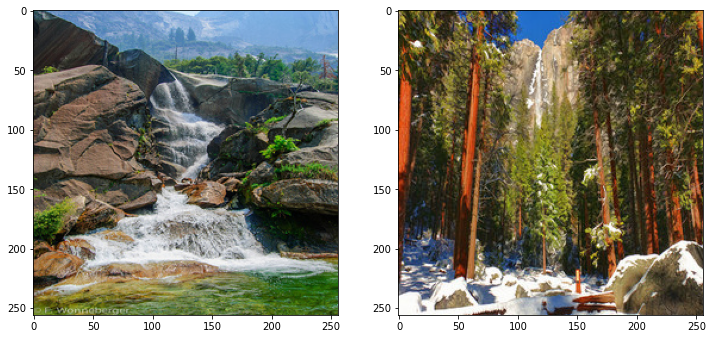

In [17]:
plt.figure(figsize=(12, 6))
for imgs_A, imgs_B in test_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow((imgs_A[0]+1)/2)
    plt.subplot(1,2,2)
    plt.imshow((imgs_B[0]+1)/2)

**Building blocks used in the CycleGAN generators and discriminators:**

In [18]:
def downsample(filters, size, apply_batchnorm=True):

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', use_bias=False))

    if apply_batchnorm:
        result.add(tfa.layers.InstanceNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [19]:
def upsample(filters, size, apply_dropout=False):

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', use_bias=False))

    result.add(tfa.layers.InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

**Build the generators:**

The generator consists of downsampling blocks: nine residual blocks and upsampling blocks.

In [20]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

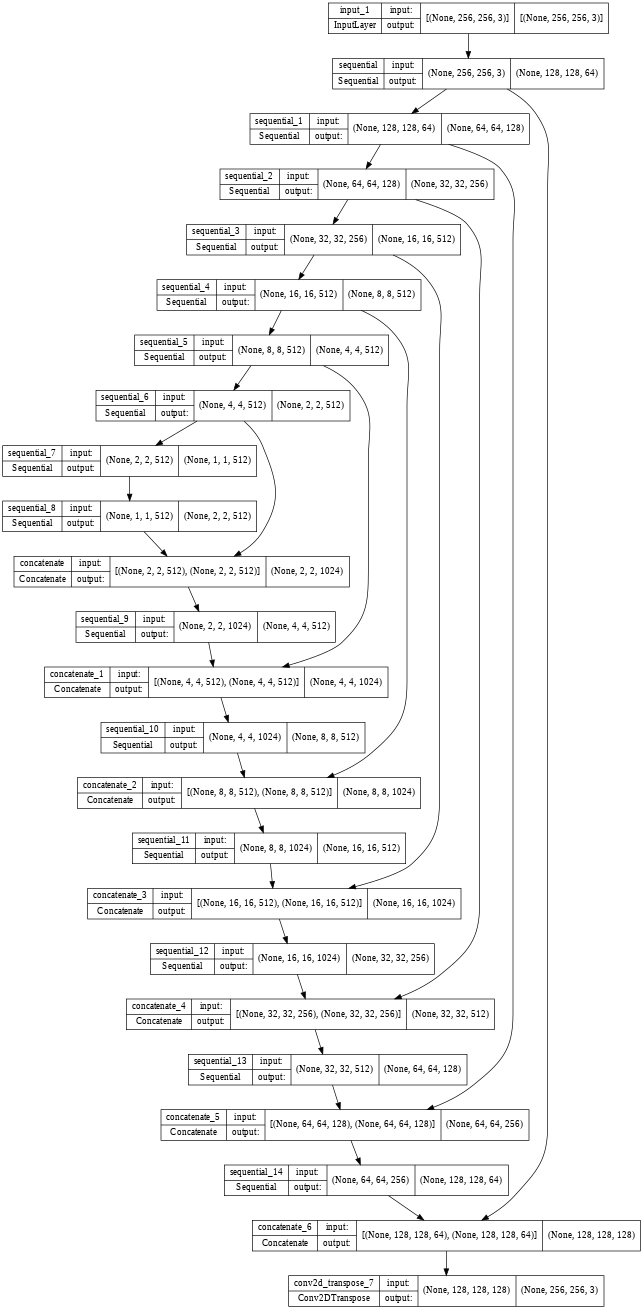

In [21]:
generator_x = Generator()   # a——>o
generator_y = Generator()   # o——>a
tf.keras.utils.plot_model(generator_x, show_shapes=True, dpi=48)

**Build the discriminators:**

The discriminators implement the following architecture: C64->C128->C256->C512

In [22]:
def Discriminator():

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')

    down1 = downsample(64, 4, False)(inp) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

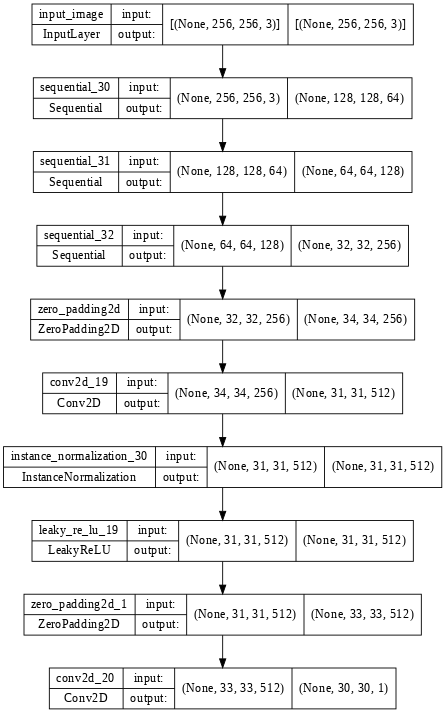

In [23]:
discriminator_x = Discriminator()   # discriminator  a
discriminator_y = Discriminator()   # discriminator  o
tf.keras.utils.plot_model(discriminator_x, show_shapes=True, dpi=64)

**Visualizing model input and output:**

In [24]:
for example_input, example_target in test_dataset.take(1):
    pass

In [25]:
def image_show():
    
    title=['Source domain','Map']
    rendered_pictures = generator_x(example_input, training=False)

    fig = plt.figure(figsize=(12, 24))

    plt.subplot(4,2,1)
    plt.imshow((example_input[0].numpy()+1)/2)
    plt.title(title[0])

    plt.subplot(4,2,2)
    plt.imshow((rendered_pictures[0].numpy()+1)/2)
    plt.title(title[1])

    plt.subplot(4,2,3)
    plt.imshow((example_input[1].numpy()+1)/2)
    plt.title(title[0])

    plt.subplot(4,2,4)
    plt.imshow((rendered_pictures[1].numpy()+1)/2)
    plt.title(title[1])

    plt.subplot(4,2,5)
    plt.imshow((example_input[2].numpy()+1)/2)
    plt.title(title[0])

    plt.subplot(4,2,6)
    plt.imshow((rendered_pictures[2].numpy()+1)/2)
    plt.title(title[1])

    plt.subplot(4,2,7)
    plt.imshow((example_input[3].numpy()+1)/2)
    plt.title(title[0])

    plt.subplot(4,2,8)
    plt.imshow((rendered_pictures[3].numpy()+1)/2)
    plt.title(title[1])

    plt.show()
    
    return rendered_pictures

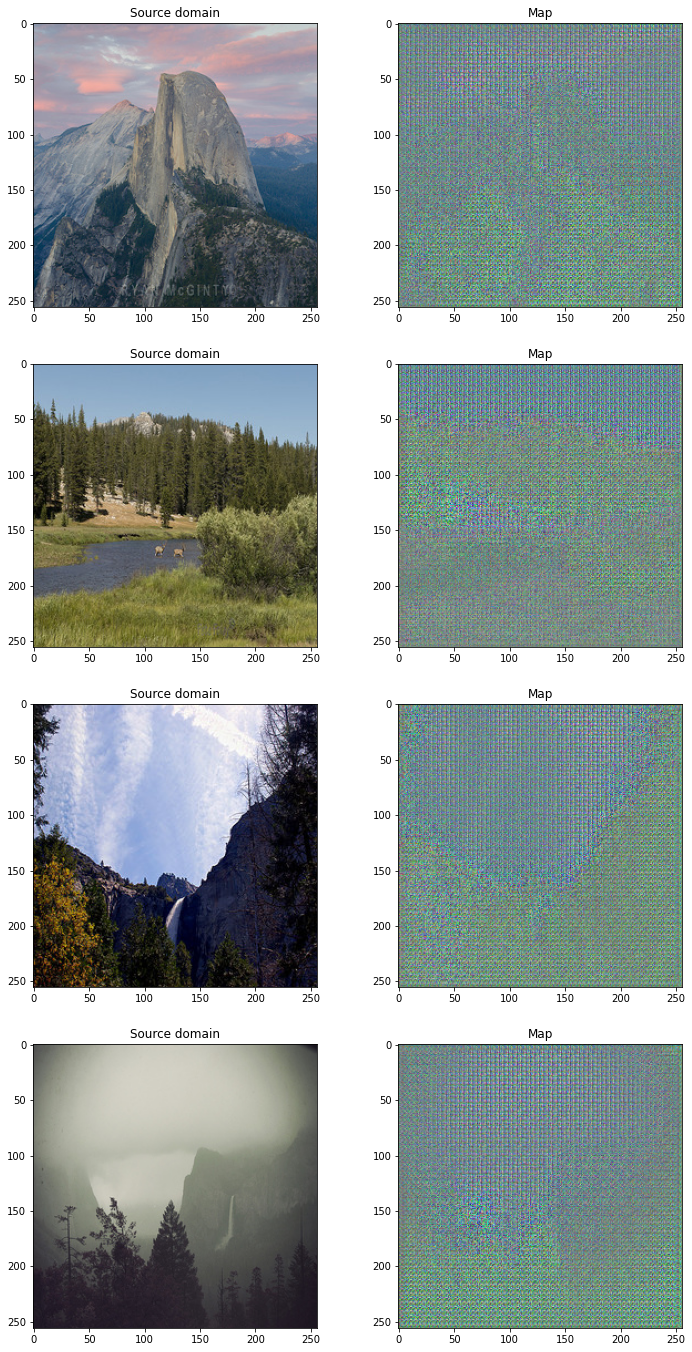

In [26]:
pred = image_show()

**Loss Calculation:**

We need to calculate different kinds of losses for the generators and discriminators.

In [27]:
def discriminator_loss(disc_real_output, disc_fake_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = loss_object(tf.zeros_like(disc_fake_output), disc_fake_output)
    total_disc_loss = real_loss + fake_loss
    return total_disc_loss

In [28]:
def generator_loss(disc_fake_output):
    gen_loss = loss_object(tf.ones_like(disc_fake_output), disc_fake_output)
    return gen_loss

In [29]:
def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

**Set the optimizers:**

In [30]:
generator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

**Train the end-to-end model:**

In [31]:
@tf.function
def train_discriminator(image_a, image_b):
    with tf.GradientTape(persistent=True) as discriminator_tape:
        #A->B->A
        fake_b = generator_x(image_a, training=True)
        cycled_a = generator_y(fake_b, training=True)
        #B->A->B
        fake_a = generator_y(image_b, training=True)
        cycled_b = generator_x(fake_a, training=True)
        #discriminator
        disc_real_a = discriminator_x(image_a, training=True)
        disc_real_b = discriminator_y(image_b, training=True)
        disc_fake_a = discriminator_x(fake_a, training=True)
        disc_fake_b = discriminator_y(fake_b, training=True)

        # Define the loss function for the discriminators
        discriminator_x_loss = discriminator_loss(disc_real_a, disc_fake_a)
        discriminator_y_loss = discriminator_loss(disc_real_b, disc_fake_b)
        
    discriminator_x_gradients = discriminator_tape.gradient(discriminator_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = discriminator_tape.gradient(discriminator_y_loss, discriminator_y.trainable_variables)
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,discriminator_y.trainable_variables))

In [32]:
@tf.function
def train_generator(image_a, image_b):
    with tf.GradientTape(persistent=True) as generator_tape:
        #A->B->A
        fake_b = generator_x(image_a, training=True)
        cycled_a = generator_y(fake_b, training=True)
        #B->A->B
        fake_a = generator_y(image_b, training=True)
        cycled_b = generator_x(fake_a, training=True)
        #discriminator
        disc_fake_a = discriminator_x(fake_a, training=True)
        disc_fake_b = discriminator_y(fake_b, training=True)

        # Define the loss function for the generators
        gen_x_loss = generator_loss(disc_fake_b)
        gen_y_loss = generator_loss(disc_fake_a)
        
        total_cycle_loss = calc_cycle_loss(image_a, cycled_a) + calc_cycle_loss(image_b, cycled_b)
        
        total_gen_x_loss = gen_x_loss + total_cycle_loss
        total_gen_y_loss = gen_y_loss + total_cycle_loss
        
    generator_x_gradients = generator_tape.gradient(total_gen_x_loss, generator_x.trainable_variables)
    generator_y_gradients = generator_tape.gradient(total_gen_y_loss, generator_y.trainable_variables)
    
    generator_x_optimizer.apply_gradients(zip(generator_x_gradients, generator_x.trainable_variables))
    generator_y_optimizer.apply_gradients(zip(generator_y_gradients, generator_y.trainable_variables))

**Compile the model:**


Epoch 1/20 
Training: [--------->] 100 %  - 209 s

Epoch 2/20 
Training: [--------->] 100 %  - 160 s

Epoch 3/20 
Training: [--------->] 100 %  - 161 s

Epoch 4/20 
Training: [--------->] 100 %  - 161 s

Epoch 5/20 
Training: [--------->] 100 %  - 161 s

Epoch 6/20 
Training: [--------->] 100 %  - 161 s

Epoch 7/20 
Training: [--------->] 100 %  - 161 s

Epoch 8/20 
Training: [--------->] 100 %  - 161 s

Epoch 9/20 
Training: [--------->] 100 %  - 161 s

Epoch 10/20 
Training: [--------->] 100 %  - 161 s

Epoch 11/20 
Training: [--------->] 100 %  - 202 s

Epoch 12/20 
Training: [--------->] 100 %  - 161 s

Epoch 13/20 
Training: [--------->] 100 %  - 161 s

Epoch 14/20 
Training: [--------->] 100 %  - 161 s

Epoch 15/20 
Training: [--------->] 100 %  - 202 s

Epoch 16/20 
Training: [--------->] 100 %  - 161 s

Epoch 17/20 
Training: [--------->] 100 %  - 202 s

Epoch 18/20 
Training: [--------->] 100 %  - 160 s

Epoch 19/20 
Training: [--------->] 100 %  - 161 s

Epoch 20/20 
Trainin

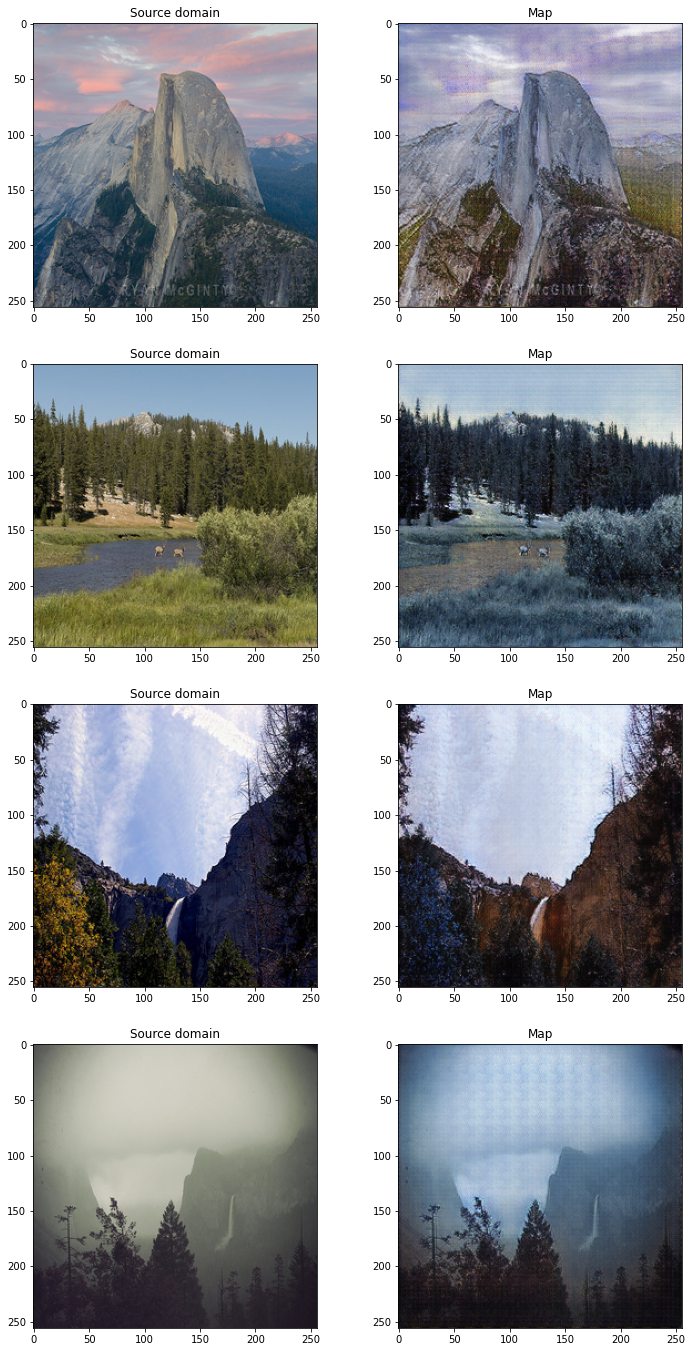

In [33]:
for epoch in range(Epochs):
    start = time.time()
    i = 0
    print ('\nEpoch {}/{} '.format(epoch+1, Epochs))
    for img_a, img_b in train_dataset:
        
        train_discriminator(img_a, img_b)
        train_generator(img_a, img_b)
        
        percent = float(i+1) * 100 / len(train_dataset)
        arrow   = '-' * int(percent/100 * 10 - 1) + '>'
        spaces  = ' ' * (10 - len(arrow))
        print('\rTraining: [%s%s] %d %% '% (arrow, spaces, percent), end='', flush=True)
        i += 1
    print(" -", int(time.time()-start), "s", end="")
    print()
    
cache = image_show()

**Create U_net**:

In [60]:
def unet_generator():
    inputs = layers.Input(shape=(256, 256, 3))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(3, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = Model(inputs, outputs)
    return model

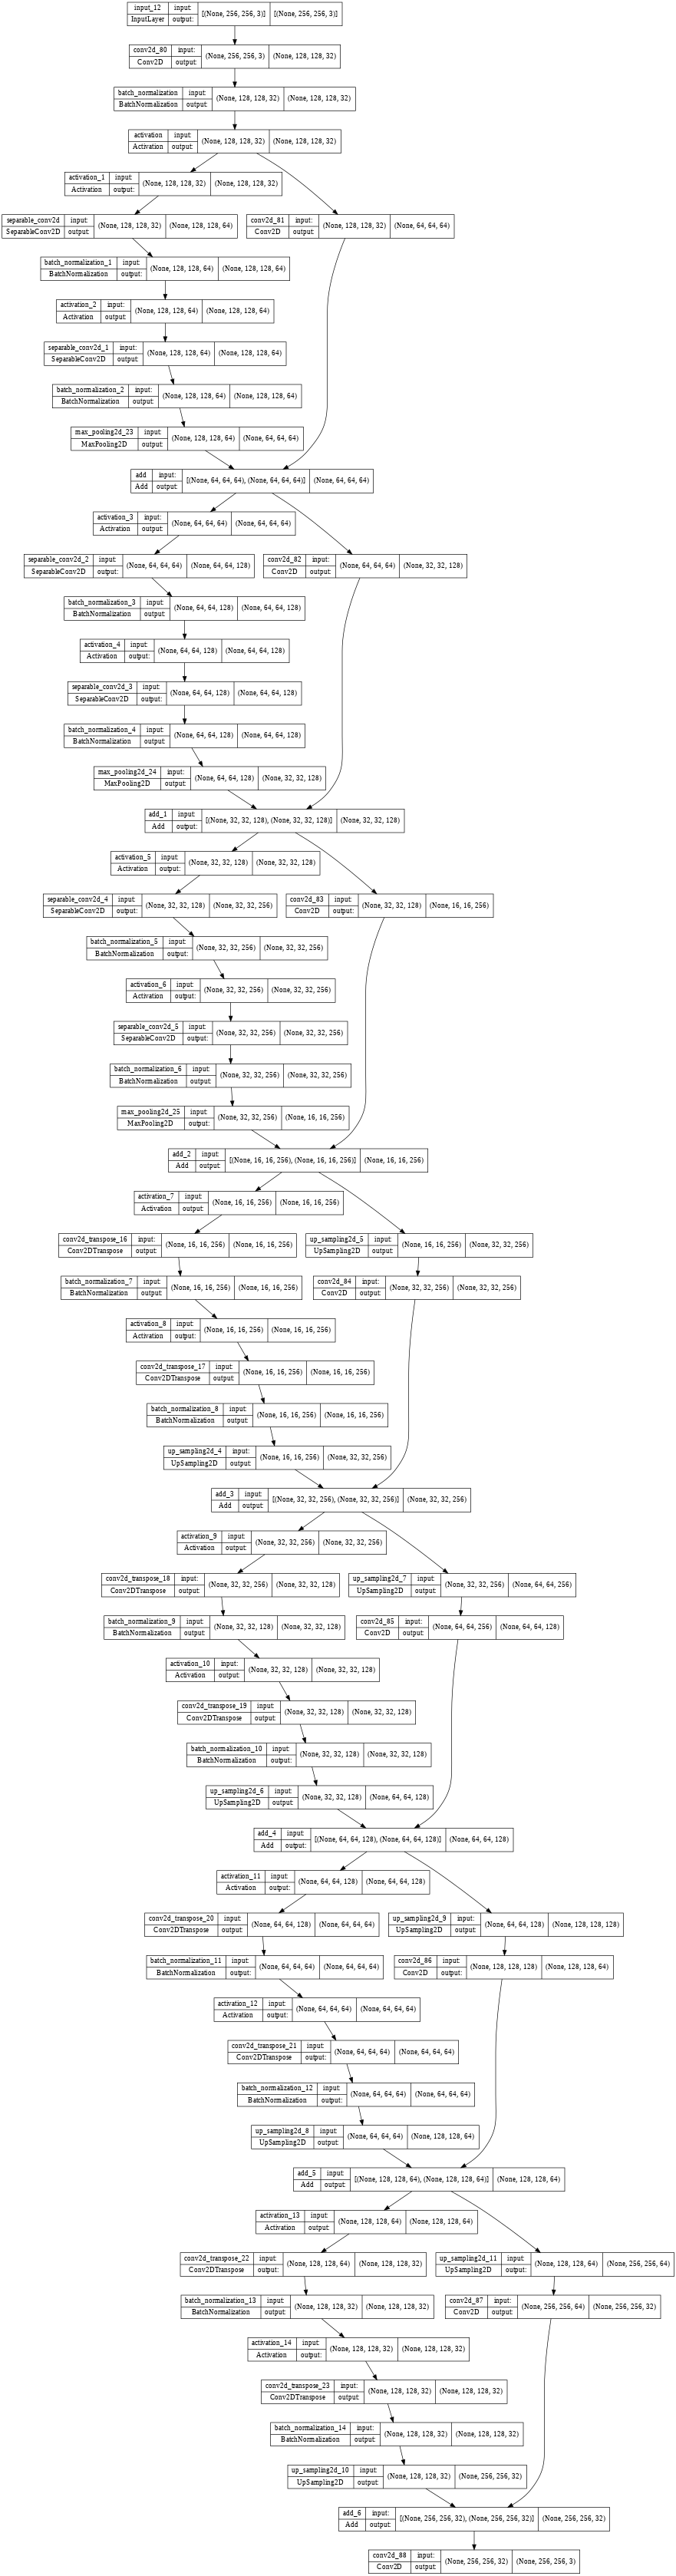

In [61]:
generator_x_unet = unet_generator()   # a——>o
generator_y_unet = unet_generator()   # o——>a
tf.keras.utils.plot_model(generator_x_unet, show_shapes=True, dpi=48)

**Train new model:**

In [62]:
@tf.function
def train_discriminator(image_a, image_b):
    with tf.GradientTape(persistent=True) as discriminator_tape:
        #A->B->A
        fake_b = generator_x_unet(image_a, training=True)
        cycled_a = generator_y_unet(fake_b, training=True)
        #B->A->B
        fake_a = generator_y_unet(image_b, training=True)
        cycled_b = generator_x_unet(fake_a, training=True)
        #discriminator
        disc_real_a = discriminator_x(image_a, training=True)
        disc_real_b = discriminator_y(image_b, training=True)
        disc_fake_a = discriminator_x(fake_a, training=True)
        disc_fake_b = discriminator_y(fake_b, training=True)

        # Define the loss function for the discriminators
        discriminator_x_loss = discriminator_loss(disc_real_a, disc_fake_a)
        discriminator_y_loss = discriminator_loss(disc_real_b, disc_fake_b)
        
    discriminator_x_gradients = discriminator_tape.gradient(discriminator_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = discriminator_tape.gradient(discriminator_y_loss, discriminator_y.trainable_variables)
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,discriminator_y.trainable_variables))

In [63]:
@tf.function
def train_generator(image_a, image_b):
    with tf.GradientTape(persistent=True) as generator_tape:
        #A->B->A
        fake_b = generator_x_unet(image_a, training=True)
        cycled_a = generator_y_unet(fake_b, training=True)
        #B->A->B
        fake_a = generator_y_unet(image_b, training=True)
        cycled_b = generator_x_unet(fake_a, training=True)
        #discriminator
        disc_fake_a = discriminator_x(fake_a, training=True)
        disc_fake_b = discriminator_y(fake_b, training=True)

        # Define the loss function for the generators
        gen_x_loss = generator_loss(disc_fake_b)
        gen_y_loss = generator_loss(disc_fake_a)
        
        total_cycle_loss = calc_cycle_loss(image_a, cycled_a) + calc_cycle_loss(image_b, cycled_b)
        
        total_gen_x_loss = gen_x_loss + total_cycle_loss
        total_gen_y_loss = gen_y_loss + total_cycle_loss
        
    generator_x_gradients = generator_tape.gradient(total_gen_x_loss, generator_x_unet.trainable_variables)
    generator_y_gradients = generator_tape.gradient(total_gen_y_loss, generator_y_unet.trainable_variables)
    
    generator_x_optimizer.apply_gradients(zip(generator_x_gradients, generator_x_unet.trainable_variables))
    generator_y_optimizer.apply_gradients(zip(generator_y_gradients, generator_y_unet.trainable_variables))

**Compile new model:**


Epoch 1/20 
Training: [--------->] 100 %  - 145 s

Epoch 2/20 
Training: [--------->] 100 %  - 142 s

Epoch 3/20 
Training: [--------->] 100 %  - 118 s

Epoch 4/20 
Training: [--------->] 100 %  - 118 s

Epoch 5/20 
Training: [--------->] 100 %  - 118 s

Epoch 6/20 
Training: [--------->] 100 %  - 118 s

Epoch 7/20 
Training: [--------->] 100 %  - 118 s

Epoch 8/20 
Training: [--------->] 100 %  - 118 s

Epoch 9/20 
Training: [--------->] 100 %  - 118 s

Epoch 10/20 
Training: [--------->] 100 %  - 118 s

Epoch 11/20 
Training: [--------->] 100 %  - 118 s

Epoch 12/20 
Training: [--------->] 100 %  - 118 s

Epoch 13/20 
Training: [--------->] 100 %  - 118 s

Epoch 14/20 
Training: [--------->] 100 %  - 118 s

Epoch 15/20 
Training: [--------->] 100 %  - 118 s

Epoch 16/20 
Training: [--------->] 100 %  - 118 s

Epoch 17/20 
Training: [--------->] 100 %  - 118 s

Epoch 18/20 
Training: [--------->] 100 %  - 118 s

Epoch 19/20 
Training: [--------->] 100 %  - 118 s

Epoch 20/20 
Trainin

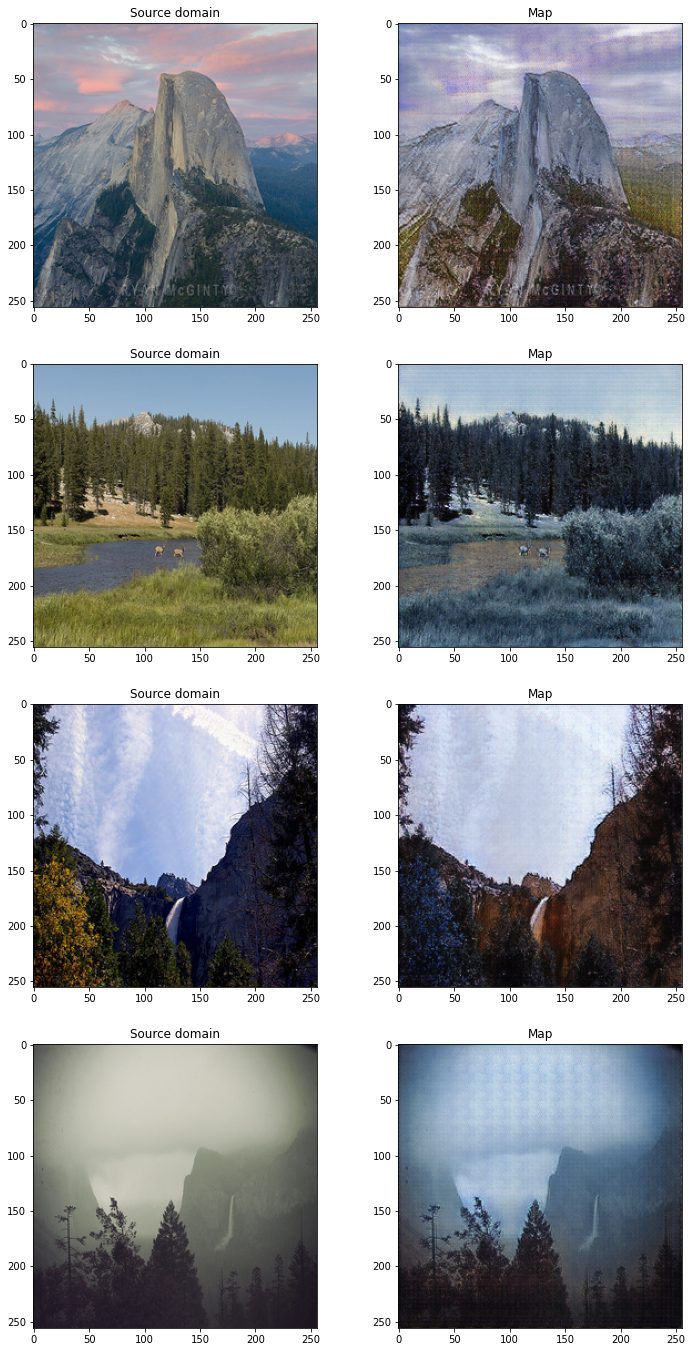

In [64]:
for epoch in range(Epochs):
    start = time.time()
    i = 0
    print ('\nEpoch {}/{} '.format(epoch+1, Epochs))
    for img_a, img_b in train_dataset:
        
        train_discriminator(img_a, img_b)
        train_generator(img_a, img_b)
        
        percent = float(i+1) * 100 / len(train_dataset)
        arrow   = '-' * int(percent/100 * 10 - 1) + '>'
        spaces  = ' ' * (10 - len(arrow))
        print('\rTraining: [%s%s] %d %% '% (arrow, spaces, percent), end='', flush=True)
        i += 1
    print(" -", int(time.time()-start), "s", end="")
    print()
    
cache = image_show()